# Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import norm, ttest_1samp
import math
import os
import shutil
import skimage as ski
import seaborn as sns
from itertools import combinations, product
from matplotlib.ticker import MaxNLocator
import ast
import glob
from scipy import stats

# Variables

In [3]:
total_hpis = 9
total_reps = 5
total_ranks = 9
subcellular_parts = ["", "_nucleii", "_cytosol"]
gene_names_3nt = ["PB2", "PB1", "PA", "HA", "NP", "NA", "M", "NS"]
barcode_dict_3nt = {"PB2": "AGC", "PB1": "CGC", "PA": "GGC", "HA": "TAC", "NP": "TCC", "NA": "TTC", "M": "TGA", "NS": "TGT"}
barcode_length = 3

def find_key_by_value(dict, target_value):
    for key, value in dict.items():
        if value == target_value:
            return key
    return None


# Mean likelihoods

## Read all spots (SBD and PBD)

In [4]:
## Read csv files
spots_sbd = pd.DataFrame()
spots_pbd = pd.DataFrame()

for rep in range(total_reps):
    for hpi in range(total_hpis):
        paths_sbd = glob.glob(f"pipeline_output/final_pipe/3nt/PR8/rep{rep}/{hpi}hpi/fov_*_spots_sbd.csv")
        paths_pbd = glob.glob(f"pipeline_output/final_pipe/3nt/PR8/rep{rep}/{hpi}hpi/fov_*_spots_pbd.csv")
        
        for path in paths_sbd:
            df_sbd = pd.read_csv(path, keep_default_na=False)
            df_sbd["rep"] = rep
            df_sbd["hpi"] = hpi
            df_sbd["fov"] = int(os.path.basename(path).split("_")[1])
            df_sbd["complex_size"] = [len(df_sbd.iloc[i]["target"].split(",")) for i in range(len(df_sbd))]
            spots_sbd = pd.concat([spots_sbd, df_sbd])
        
        for path in paths_pbd:
            df_pbd = pd.read_csv(path, keep_default_na=False)
            df_pbd["rep"] = rep
            df_pbd["hpi"] = hpi
            df_pbd["fov"] = int(os.path.basename(path).split("_")[1])
            df_pbd["complex_size"] = [len(df_pbd.iloc[i]["target"].split(",")) for i in range(len(df_pbd))]
            spots_pbd = pd.concat([spots_pbd, df_pbd])

In [5]:
## filter for valid spots and density
spots_sbd = spots_sbd[(~spots_sbd["target"].str.contains("invalid")) & (~spots_sbd["target"].str.contains("missing"))]
spots_sbd = spots_sbd[spots_sbd["densed_region_filtered"] == False]
spots_pbd = spots_pbd[spots_pbd["densed_region_filtered"] == True]
spots_pbd = spots_pbd[(spots_pbd["radius"] >= 1) & (spots_pbd["radius"] <= 12)]

## format spots pbd
spots_pbd_formatted = pd.DataFrame()
for rank in range(2,9):
    for possible_complex in list(combinations(gene_names_3nt, rank)):
        possible_complex = list(possible_complex)
        possible_complex_sort = sorted(possible_complex)
        spots_to_reorder = spots_pbd[(spots_pbd["complex_size"] == rank) & (spots_pbd["target"] == ",".join(possible_complex_sort))].copy()
        spots_to_reorder["target"] = ",".join(possible_complex)
        spots_pbd_formatted = pd.concat([spots_pbd_formatted, spots_to_reorder])

## concat sbd and pbd
spots = pd.concat([spots_sbd, spots_pbd[spots_pbd["complex_size"] == 1], spots_pbd_formatted])
spots.to_csv("data/all_spots.csv", index=False)
spots_sbd.to_csv("data/all_spots_sbd.csv", index=False)
spots

,intensity,z,y,x,radius,spot_id,z_min,z_max,y_min,y_max,...,cell,boundary_dist,border_cell,densed_region,densed_region_filtered,rep,hpi,fov,complex_size,iter
0,0.361260,0.0,1217,1157,4.000000,0,0.0,1.0,1214.0,1221.0,...,51,10.630146,False,False,False,0,0,1,2,NaN
1,0.001205,0.0,1078,482,3.000000,1,0.0,1.0,1076.0,1081.0,...,43,29.068884,False,False,False,0,0,1,1,NaN
2,0.005784,0.0,1201,1089,4.000000,2,0.0,1.0,1198.0,1205.0,...,51,31.827661,False,False,False,0,0,1,1,NaN
3,0.007471,0.0,678,868,3.000000,3,0.0,1.0,676.0,681.0,...,24,67.201190,False,False,False,0,0,1,1,NaN
5,0.003133,0.0,794,1636,4.000000,5,0.0,1.0,791.0,798.0,...,27,9.219544,False,False,False,0,0,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19087,NaN,NaN,642,93,1.222222,19087,NaN,NaN,NaN,NaN,...,0,8.485281,True,True,True,4,8,6,8,2.0
21274,NaN,NaN,851,158,1.416394,21274,NaN,NaN,NaN,NaN,...,0,85.866175,True,True,True,4,8,6,8,2.0
21388,NaN,NaN,859,38,1.222222,21388,NaN,NaN,NaN,NaN,...,0,68.876701,True,True,True,4,8,6,8,2.0
24446,NaN,NaN,1093,328,1.400000,24446,NaN,NaN,NaN,NaN,...,0,157.276826,True,True,True,4,8,6,8,2.0


## Calculate complex counts

In [9]:
spots = pd.read_csv("data/all_spots_sbd.csv", keep_default_na=False, low_memory=False)
spots = spots[~ spots["target"].str.contains("invalid|missing")]
#spots = pd.read_csv("results/all_spots_sbd.csv", keep_default_na=False, low_memory=False)
compartment = ""

if compartment == "_nucleus":
    spots = spots[spots["nucleus"] == True]
elif compartment == "_cytosol":
    spots = spots[spots["nucleus"] == False]

for rep in range(total_reps):
    spots_rep = spots[spots["rep"] == rep]
    complex_counts = pd.DataFrame()

    for hpi in range(total_hpis):
        for rank in range(1, total_ranks):
            spots_rep_hpi_rank = spots_rep[(spots_rep["hpi"] == hpi) & (spots_rep["complex_size"] == rank)]

            for complex in list(combinations(gene_names_3nt, rank)):
                df = pd.DataFrame({
                    "hpi": [hpi],
                    "complex_size": [rank],
                    "complex": [",".join(list(complex))],
                    "n": [len(spots_rep_hpi_rank[spots_rep_hpi_rank["target"] == ",".join(list(complex))])]
                })

                complex_counts = pd.concat([complex_counts, df])
        
    complex_counts.to_csv(f"data/complex_counts/complex_counts_rep{rep}{compartment}_sbd.csv", index=False)

## Calculate complex likelihoods

In [18]:
spots = pd.read_csv("data/all_spots_sbd.csv", keep_default_na=False, low_memory=False)
spots = spots[~ spots["target"].str.contains("invalid|missing")]
likelihoods = pd.DataFrame()
compartment = ""

for rank in range(1, 9):
    for rep in range(total_reps):
        complex_counts = pd.read_csv(f"data/complex_counts/complex_counts_rep{rep}{compartment}_sbd.csv", keep_default_na=False)

        for hpi in range(total_hpis):
            df = spots[(spots["rep"] == rep) & (spots["hpi"] == hpi)]

            ## calculate the relative abundance of every gene within the hpi
            gene_counts = pd.DataFrame()
            for i, gene in enumerate(gene_names_3nt):
                gene_counts = pd.concat([gene_counts, pd.DataFrame([{"gene": gene, "abundance": len(df[df["target"].str.contains(gene)])}])])
            gene_counts["relative_abundance"] = gene_counts["abundance"] / gene_counts["abundance"].sum()

            ## calculate the relative abundance of every complex within the rank
            complex_counts_hpi = complex_counts[complex_counts["hpi"] == hpi].copy()
            complex_counts_hpi["relative_abundance"] = (complex_counts_hpi.groupby("complex_size")["n"].transform(lambda x: x / x.sum()))

            ## claculate the probability of every complex based by multiplying the relative abundances of every segment
            complex_probabilities = []
            for i in range(len(complex_counts_hpi)):
                complex_genes = complex_counts_hpi.iloc[i].complex.split(",")
                complex_probability = 1          

                for gene in complex_genes:
                    complex_probability *= gene_counts.loc[gene_counts["gene"] == gene, "relative_abundance"].values[0]

                complex_probabilities.append(complex_probability)
            

            complex_counts_hpi["complex_probability"] = complex_probabilities

            ## Normalization of the complex probabilities within their rank
            complex_counts_hpi_rank = complex_counts_hpi[complex_counts_hpi["complex_size"] == rank].copy()
            normalized_complex_probabilities = []
            sum_of_probabilities = complex_counts_hpi_rank["complex_probability"].sum()

            for i in range(len(complex_counts_hpi_rank)):
                normalized_complex_probability = complex_counts_hpi_rank.iloc[i]["complex_probability"] / sum_of_probabilities
                normalized_complex_probabilities.append(normalized_complex_probability)

            complex_counts_hpi_rank["normalized_complex_probability"] = normalized_complex_probabilities
            complex_counts_hpi_rank.insert(column="rep", value=rep, loc=0)

            complex_counts_hpi_rank.loc[complex_counts_hpi_rank["n"] == 0, "relative_abundance"] = 0
            likelihoods = pd.concat([likelihoods, complex_counts_hpi_rank])

likelihoods.to_csv(f"data/complex_likelihoods{compartment}_sbd.csv", index=False)
likelihoods

,rep,hpi,complex_size,complex,n,relative_abundance,complex_probability,normalized_complex_probability
0,0,0,1,PB2,57,0.007788,9.457507e-03,0.009458
1,0,0,1,PB1,441,0.060254,6.134244e-02,0.061342
2,0,0,1,PA,1005,0.137314,1.381847e-01,0.138185
3,0,0,1,HA,323,0.044132,4.768160e-02,0.047682
4,0,0,1,NP,721,0.098511,1.000919e-01,0.100092
...,...,...,...,...,...,...,...,...
1274,4,4,8,"PB2,PB1,PA,HA,NP,NA,M,NS",0,0.000000,1.197846e-08,1.000000
1529,4,5,8,"PB2,PB1,PA,HA,NP,NA,M,NS",2,1.000000,2.754938e-08,1.000000
1784,4,6,8,"PB2,PB1,PA,HA,NP,NA,M,NS",0,0.000000,1.454095e-08,1.000000
2039,4,7,8,"PB2,PB1,PA,HA,NP,NA,M,NS",1,1.000000,1.136293e-08,1.000000


## Mean likelihoods across hpis

In [13]:
from functions import pivot_replicates
from scipy.stats import ttest_ind
import warnings

In [19]:
compartment = ""

likelihoods = pd.read_csv(f"data/complex_likelihoods{compartment}_sbd.csv", keep_default_na=False)
index_cols = ["hpi", "complex_size", "complex"]
value_cols = ["n", "relative_abundance", "complex_probability", "normalized_complex_probability"]
mean_likelihoods = pivot_replicates(likelihoods, index_cols, value_cols)

rel_abund_cols = [col for col in mean_likelihoods.columns if col.startswith("relative_abundance_rep")]
norm_prob_cols = [col for col in mean_likelihoods.columns if col.startswith("normalized_complex_probability_rep")]

def ttest_rowwise(row):
    group1 = row[rel_abund_cols].values.astype(float)
    group2 = row[norm_prob_cols].values.astype(float)
    
    with warnings.catch_warnings(record=True) as w:
        t_stat, p_value =ttest_ind(group1, group2, equal_var=False)
        warnings_triggered = any(issubclass(wi.category, RuntimeWarning) for wi in w)

    return pd.Series({"ttest_tvalue": t_stat, "ttest_pvalue": p_value, "ttest_warning": warnings_triggered})

mean_likelihoods[["ttest_tvalue", "ttest_pvalue", "ttest_warning"]] = mean_likelihoods.apply(ttest_rowwise, axis=1)
mean_likelihoods.to_csv(f"data/mean_complex_likelihoods{compartment}_sbd.csv", index=False)

## Plot mean likelihood 

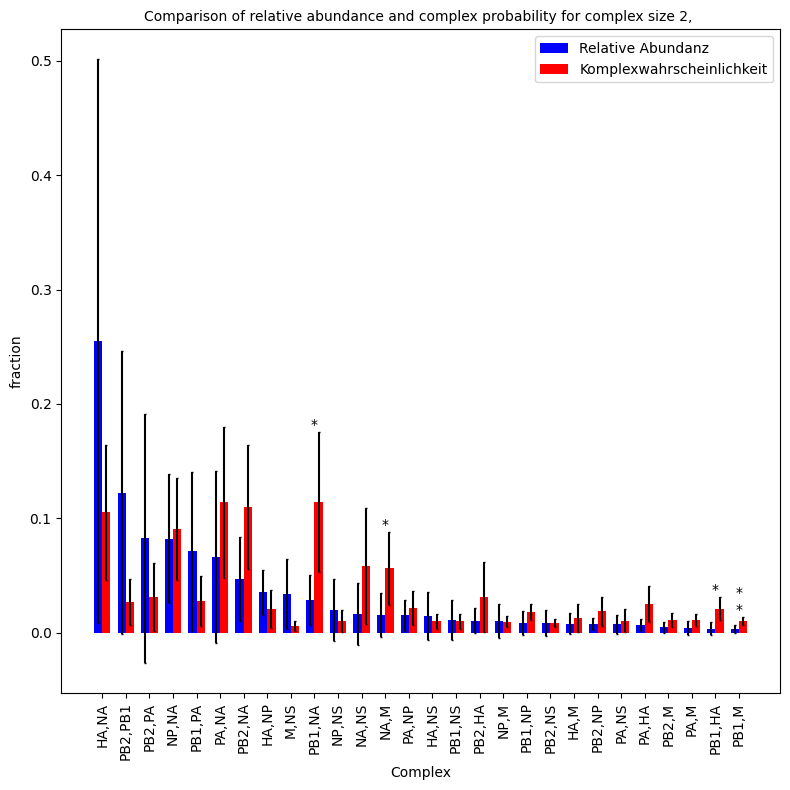

28 out of 28 possible complexes were detected


In [ ]:
compartment = ""
rank = 2
hpi = 3

mean_likelihoods = pd.read_csv(f"data/mean_complex_likelihoods{compartment}_sbd.csv", keep_default_na=False)
df = mean_likelihoods[(mean_likelihoods["hpi"] == hpi) & (mean_likelihoods["complex_size"] == rank)]
df = df.sort_values("relative_abundance_mean", ascending=False)
x_vals = df["complex"].unique()
y_rel_abund = df["relative_abundance_mean"].values
y_norm_compl_prob = df["normalized_complex_probability_mean"].values
x = np.arange(len(df))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(8,8))
ax.bar(x - bar_width/2, y_rel_abund, bar_width, label="relative abundance", color="blue", yerr=df["relative_abundance_std"], capsize=1)
ax.bar(x + bar_width/2, y_norm_compl_prob, bar_width, label="complex probability", color="red", yerr=df["normalized_complex_probability_std"], capsize=1)

for i in range(len(df)):  ## Signifikanzen
    y_max_all = max(df["relative_abundance_mean"] + df["normalized_complex_probability_mean"])
    y_max = max(df["relative_abundance_mean"].iloc[i] + df["relative_abundance_std"].iloc[i], df["normalized_complex_probability_mean"].iloc[i] + df["normalized_complex_probability_std"].iloc[i])
    if np.float32(df["ttest_pvalue"].iloc[i]) < 0.05:
        ax.text(i, y_max, "*", ha="center", va="bottom", fontsize=10)
    if np.float32(df["ttest_pvalue"].iloc[i]) < 0.01:
        ax.text(i, y_max + y_max_all/25, "*", ha="center", va="bottom", fontsize=10)
    if np.float32(df["ttest_pvalue"].iloc[i]) < 0.001:
        ax.text(i, y_max + 2*y_max_all/25, "*", ha="center", va="bottom", fontsize=10)

ax.set_xlabel("Complex")
ax.set_ylabel("fraction")
ax.set_title(f"Comparison of relative abundance and complex probability for complex size {rank}, {compartment}", fontsize=10)
ax.set_xticks(x)
ax.set_xticklabels(x_vals, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

n_combinations = math.factorial(len(gene_names_3nt)) / (math.factorial(rank) * math.factorial((len(gene_names_3nt) - rank)))
print(f"{len(df)} out of {round(n_combinations)} possible complexes were detected")

## Mean likelihoods 4-6 hpi

In [30]:
mean_likelihoods = pd.read_csv(f"data/mean_complex_likelihoods_sbd.csv", keep_default_na=False)
ml_hpi46 = pd.DataFrame()

for i, group in mean_likelihoods.groupby(["complex_size", "complex"]):
    group = group.query("hpi>=4 & hpi<=6")
    vals_rel = list(group["relative_abundance_rep0"].values) + list(group["relative_abundance_rep1"].values) + list(group["relative_abundance_rep2"].values) + list(group["relative_abundance_rep3"].values) + list(group["relative_abundance_rep4"].values)
    mean_rel = np.mean(vals_rel)
    std_rel = np.std(vals_rel, ddof=1)

    vals_norm = list(group["normalized_complex_probability_rep0"].values) + list(group["normalized_complex_probability_rep1"].values) + list(group["normalized_complex_probability_rep2"].values) + list(group["normalized_complex_probability_rep3"].values) + list(group["normalized_complex_probability_rep4"].values)
    mean_norm = np.mean(vals_norm)
    std_norm = np.std(vals_norm, ddof=1)

    t_stat, p_val = stats.ttest_ind(vals_rel, vals_norm, equal_var=False) 

    df = pd.DataFrame({
        "complex_size": [group.iloc[0]["complex_size"]],
        "complex": [group.iloc[0]["complex"]],
        "mean_rel_ab": [mean_rel],
        "std_rel_ab": [std_rel],
        "mean_norm": [mean_norm],
        "std_norm": [std_norm],
        "p_val": [p_val]
    })
    ml_hpi46 = pd.concat([ml_hpi46, df])

ml_hpi46.to_csv("data/mean_likelihoods_hpi4_6.csv", index=False, sep=";", encoding="utf-8-sig")
ml_hpi46

/home/witte/miniconda3/envs/starfish/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,complex_size,complex,mean_rel_ab,std_rel_ab,mean_norm,std_norm,p_val
0,1,HA,0.069762,0.016479,0.084918,0.016696,0.018455
0,1,M,0.164961,0.110016,0.132966,0.071733,0.354786
0,1,NA,0.383809,0.157673,0.287703,0.103143,0.059751
0,1,NP,0.084684,0.033061,0.095797,0.036253,0.387868
0,1,NS,0.120796,0.066826,0.112141,0.061566,0.714968
...,...,...,...,...,...,...,...
0,7,"PB2,PB1,PA,HA,NP,M,NS",0.014394,0.038528,0.045395,0.020110,0.011633
0,7,"PB2,PB1,PA,HA,NP,NA,M",0.104507,0.186065,0.121982,0.048217,0.729379
0,7,"PB2,PB1,PA,HA,NP,NA,NS",0.127350,0.283317,0.105673,0.046749,0.774064
0,7,"PB2,PB1,PA,NP,NA,M,NS",0.028788,0.077056,0.134497,0.024505,0.000099


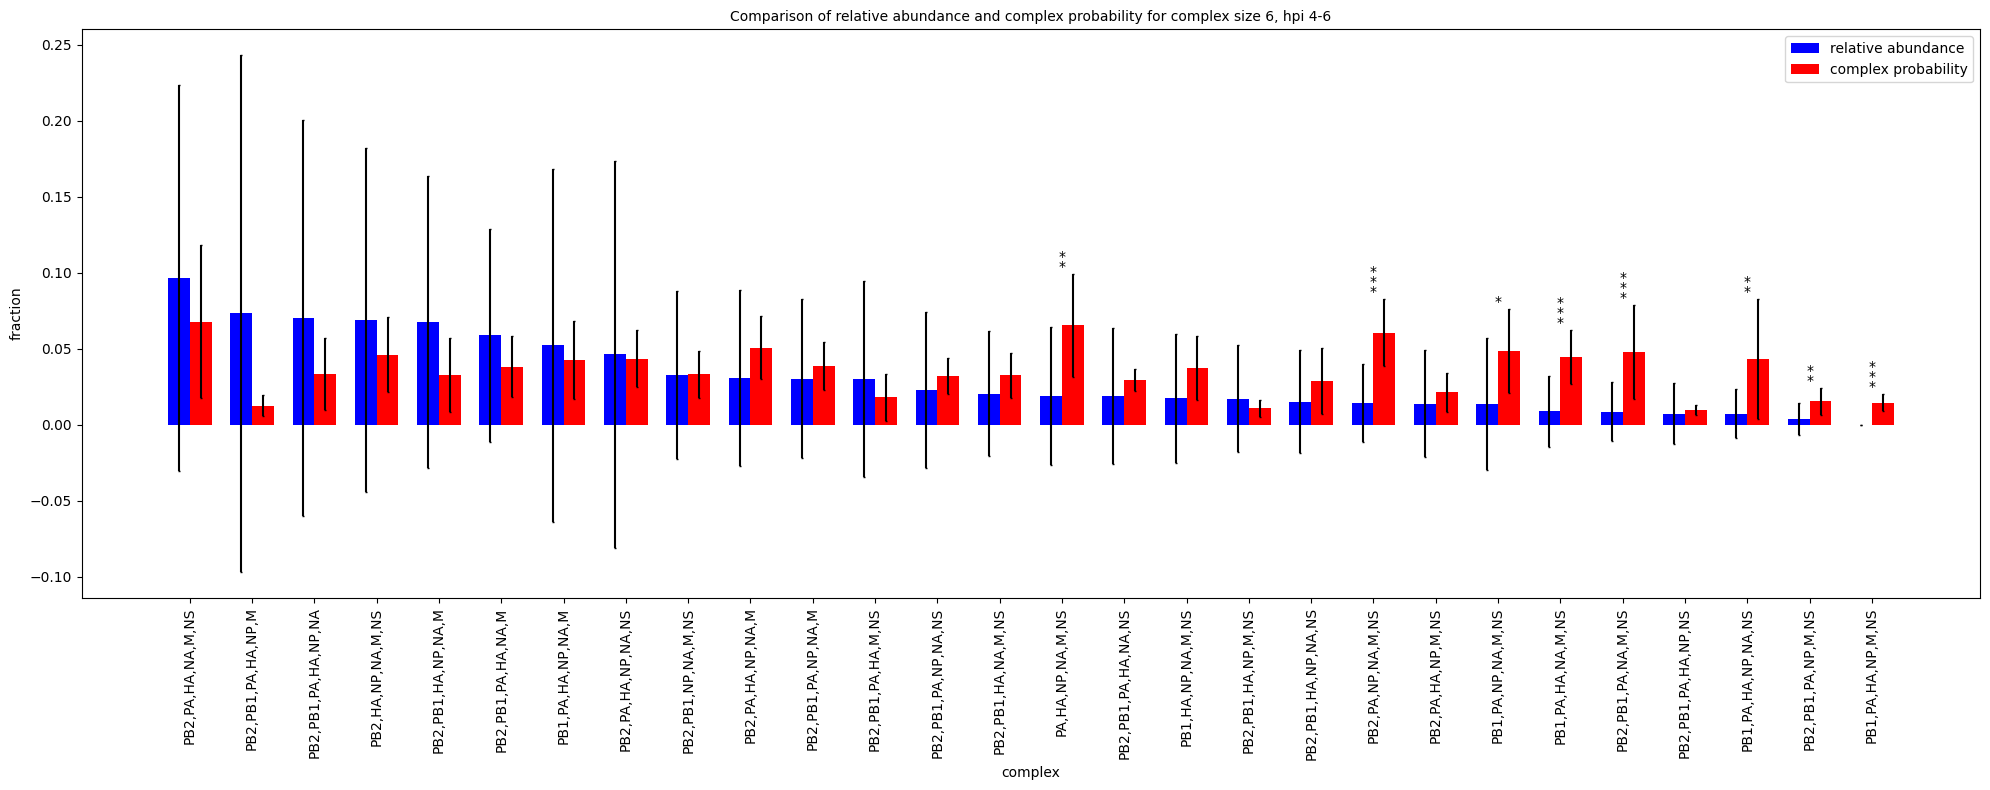

28 out of 28 possible complexes were detected


In [34]:
rank = 6
ml_hpi46 = pd.read_csv("data/mean_likelihoods_hpi4_6.csv", keep_default_na=False, sep=";")
ml_hpi46 = ml_hpi46.query("complex_size==@rank")
ml_hpi46 = ml_hpi46.sort_values("mean_rel_ab", ascending=False)
x_vals = ml_hpi46["complex"].unique()
y_rel_abund = ml_hpi46["mean_rel_ab"].values
y_norm_compl_prob = ml_hpi46["mean_norm"].values
x = np.arange(len(ml_hpi46))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(20,8))
ax.bar(x - bar_width/2, y_rel_abund, bar_width, label="relative abundance", color="blue", yerr=ml_hpi46["std_rel_ab"], capsize=1)
ax.bar(x + bar_width/2, y_norm_compl_prob, bar_width, label="complex probability", color="red", yerr=ml_hpi46["std_norm"], capsize=1)

for i in range(len(ml_hpi46)):  ## Signifikanzen
    y_max_all = max(ml_hpi46["mean_rel_ab"] + ml_hpi46["mean_norm"])
    y_max = max(ml_hpi46["mean_rel_ab"].iloc[i] + ml_hpi46["std_rel_ab"].iloc[i], ml_hpi46["mean_norm"].iloc[i] + ml_hpi46["std_norm"].iloc[i])
    if np.float32(ml_hpi46["p_val"].iloc[i]) < 0.05:
        ax.text(i, y_max, "*", ha="center", va="bottom", fontsize=10)
    if np.float32(ml_hpi46["p_val"].iloc[i]) < 0.01:
        ax.text(i, y_max + y_max_all/25, "*", ha="center", va="bottom", fontsize=10)
    if np.float32(ml_hpi46["p_val"].iloc[i]) < 0.001:
        ax.text(i, y_max + 2*y_max_all/25, "*", ha="center", va="bottom", fontsize=10)

ax.set_xlabel("complex")
ax.set_ylabel("fraction")
ax.set_title(f"Comparison of relative abundance and complex probability for complex size {rank}, hpi 4-6", fontsize=10)
ax.set_xticks(x)
ax.set_xticklabels(x_vals, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

n_combinations = math.factorial(len(gene_names_3nt)) / (math.factorial(rank) * math.factorial((len(gene_names_3nt) - rank)))
print(f"{len(ml_hpi46)} out of {round(n_combinations)} possible complexes were detected")

## Plot mean likelihoods of single complexes

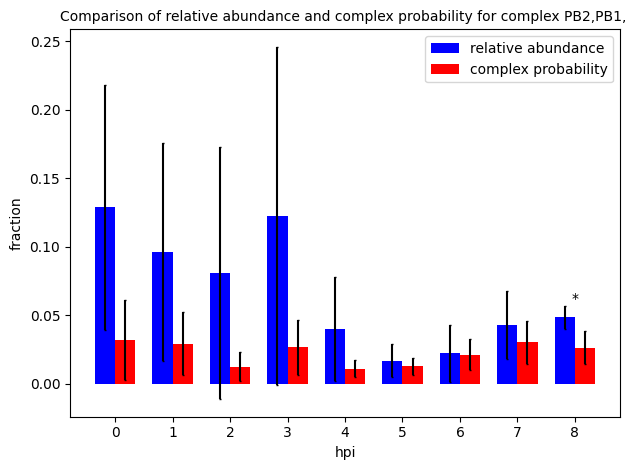

In [37]:
complex = "PB2,PB1"
compartment = ""
rank = len(complex.split(","))

mean_likelihoods = pd.read_csv(f"data/mean_complex_likelihoods{compartment}_sbd.csv", keep_default_na=False)
df = mean_likelihoods[(mean_likelihoods["complex_size"] == rank) & (mean_likelihoods["complex"] == complex)]

x_vals = np.arange(total_hpis)
y_rel_abund = df["relative_abundance_mean"].values
y_norm_compl_prob = df["normalized_complex_probability_mean"].values
x = np.arange(len(df))
bar_width = 0.35

fig, ax = plt.subplots()
ax.bar(x - bar_width/2, y_rel_abund, bar_width, label="relative abundance", color="blue", yerr=df["relative_abundance_std"], capsize=1)
ax.bar(x + bar_width/2, y_norm_compl_prob, bar_width, label="complex probability", color="red", yerr=df["normalized_complex_probability_std"], capsize=1)

for i in range(len(df)):  ## Signifikanzen
    y_max_all = max(df["relative_abundance_mean"] + df["normalized_complex_probability_mean"])
    y_max = max(df["relative_abundance_mean"].iloc[i] + df["relative_abundance_std"].iloc[i], df["normalized_complex_probability_mean"].iloc[i] + df["normalized_complex_probability_std"].iloc[i])
    if np.float32(df["ttest_pvalue"].iloc[i]) < 0.05:
        ax.text(i, y_max, "*", ha="center", va="bottom", fontsize=10)
    if np.float32(df["ttest_pvalue"].iloc[i]) < 0.01:
        ax.text(i, y_max + y_max_all/25, "*", ha="center", va="bottom", fontsize=10)
    if np.float32(df["ttest_pvalue"].iloc[i]) < 0.001:
        ax.text(i, y_max + 2*y_max_all/25, "*", ha="center", va="bottom", fontsize=10)

ax.set_xlabel("hpi")
ax.set_ylabel("fraction")
ax.set_title(f"Comparison of relative abundance and complex probability for complex {complex}, {compartment}", fontsize=10)
ax.set_xticks(x)
ax.set_xticklabels(x_vals)
ax.legend()
plt.tight_layout()
plt.show()

# Mean error simulation

## Simulation all

In [4]:
from functions import simulated_error

At rank 8, the normalized complex probability equals 1, since there is only a single complex (complex probability / sum of all complexes).
If the relative abundance equals 0, the observed mean error is 1 (complex probability – relative abundance = 1 – 0 = 1).


In [24]:
compartment = ""

mean_likelihoods = pd.read_csv(f"data/mean_complex_likelihoods{compartment}_sbd.csv", keep_default_na=False)
mean_likelihoods["n_sum"] = mean_likelihoods[["n_rep0", "n_rep1", "n_rep2", "n_rep3", "n_rep4"]].sum(axis=1)
mean_errors = pd.DataFrame()

for rank in range(2, 8):
    for hpi in range(total_hpis):
        df = mean_likelihoods[(mean_likelihoods["complex_size"] == rank) & (mean_likelihoods["hpi"] == hpi)]
        result_folder = f"data/mean_error_simulation/mean_error_simulation{compartment}/rank{rank}"
        os.makedirs(result_folder, exist_ok=True)
        simulated_mean_error, observed_mean_error, p_value, p_value_corrected, p_value_1sided = simulated_error(100, df, f"{result_folder}/hpi{hpi}")

        mean_errors = pd.concat([mean_errors, pd.DataFrame({
            "rank": [rank],
            "hpi": [hpi],
            "observed_mean_error": [observed_mean_error],
            "simulated_mean_error": [simulated_mean_error],
            "ttest_pvalue": [p_value],
            "p_value_corrected": [p_value_corrected],
            "p_value_1sided": [p_value_1sided]
        })])

mean_errors.to_csv(f"data/mean_error_simulation{compartment}_sbd.csv", index=False)
mean_errors.head()

,rank,hpi,observed_mean_error,simulated_mean_error,ttest_pvalue,p_value_corrected,p_value_1sided
0,2,0,0.029015,0.004678,0.0,0.0,0.0
0,2,1,0.025964,0.003942,0.0,0.0,0.0
0,2,2,0.030441,0.003985,0.0,0.0,0.0
0,2,3,0.028536,0.002876,0.0,0.0,0.0
0,2,4,0.018416,0.002387,0.0,0.0,0.0


## Heatmap

In [25]:
from matplotlib.colors import ListedColormap

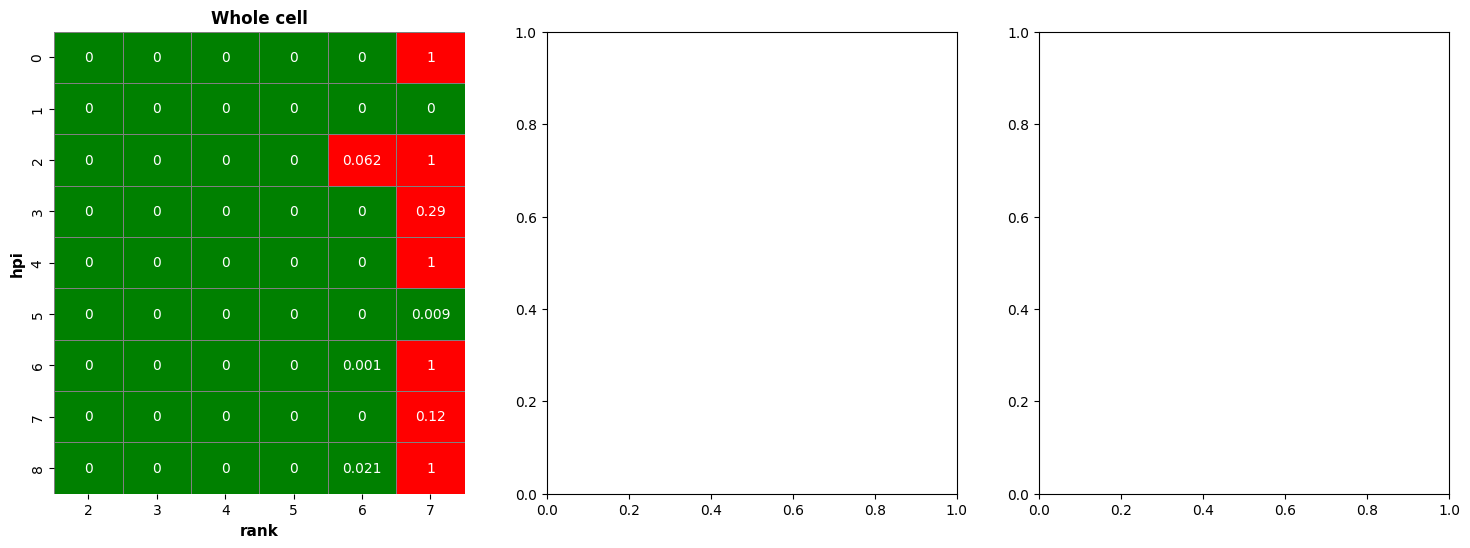

In [26]:
compartments = [""]#["", "_nucleus", "_cytosol"]
titles = ["Whole cell", "Nucleus", "Cytosol"]

fig, axs = plt.subplots(1, 3, figsize=(18,6))

for i, compartment in enumerate(compartments):
    mean_errors = pd.read_csv(f"data/mean_error_simulation{compartment}_sbd.csv")
    df_heatmap = pd.DataFrame()

    for rank in range(2, 8):
        p_values = mean_errors[mean_errors["rank"] == rank]["p_value_1sided"].values
        df_heatmap[f"{rank}"] = p_values

    mask_colors = np.where(df_heatmap.values <= 0.05, 0, 1)
    cmap = ListedColormap(["green", "red"])

    sns.heatmap(mask_colors, annot=df_heatmap.round(3), cmap=cmap, cbar=False, ax=axs[i], linewidths=0.5, linecolor="gray")
    axs[i].set_title(titles[i], fontsize=12, fontweight="bold")
    axs[i].set_ylabel("hpi", fontsize=11, fontweight="bold")
    axs[i].set_xlabel("rank", fontsize=11, fontweight="bold")
    axs[i].set_xticklabels(np.arange(2, 8))
    axs[i].set_yticks(np.arange(len(df_heatmap)) + 0.5)
    axs[i].set_yticklabels(df_heatmap.index)

#plt.savefig("heatmaps.svg")

# Barcode bias

## Calculating barcode distances

In [27]:
barcode_distances = pd.DataFrame()

for rank in range(2,9):
    ## Berechnung aller möglichen Komplexe
    possible_complexes = list(combinations(gene_names_3nt, rank))
    complexes = []

    ## Komplexe richtig Formatieren
    for complex in possible_complexes:
        genes = [complex[i] for i in range(rank)]
        compl = f"{genes[0]}"
        for i in range(1, len(genes)):
            compl += f",{genes[i]}"
        complexes.append(compl)

    active_channels_list = []
    active_channels_sums = []
    channel_ranges = []
    bases_runs = {
        "run1": [],
        "run2": [],
        "run3": []
    }

    ## Aktive Kanäle pro Sequenzierrunde brechnen
    for complex in complexes:
        complex_dict = {}
        genes = complex.split(",")
        active_channels = []
        channel_bases = []

        for i in range(rank):
            complex_dict[f"gene_{i}"] = genes[i]
            complex_dict[f"barcode_gene_{i}"] = barcode_dict_3nt[genes[i]]


        for base in range(barcode_length):
            bases = [complex_dict[f"barcode_gene_{i}"][base] for i in range(rank)]
            active_channels_base = len(set(bases))

            active_channels.append(active_channels_base)
            channel_bases.append(bases)
            bases_runs[f"run{base + 1}"].append(bases)

        active_channels_sum = sum(active_channels)

        active_channels_list.append(active_channels)
        active_channels_sums.append(active_channels_sum)
        channel_ranges.append(max(active_channels) - min(active_channels))

    df = pd.DataFrame({
        "rank": rank,
        "complexes": complexes,
        "active_channels": active_channels_list,
        "active_channels_sum": active_channels_sums,
        "active_channels_range": channel_ranges,
        "bases_run1": bases_runs["run1"],
        "bases_run2": bases_runs["run2"],
        "bases_run3": bases_runs["run3"],
    })
    
    barcode_distances = pd.concat([barcode_distances, df])

barcode_distances.to_csv(f"data/barcode_distances.csv", index=False)

## Plot distances

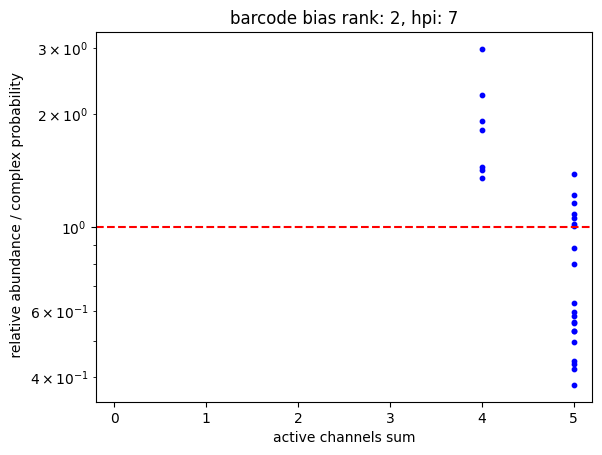

In [28]:
rank = 2
hpi = 7

barcode_distances = pd.read_csv(f"data/barcode_distances.csv")
mean_likelihoods = pd.read_csv(f"data/mean_complex_likelihoods_sbd.csv", keep_default_na=False)
mean_likelihoods = mean_likelihoods[(mean_likelihoods["complex_size"] == rank) & (mean_likelihoods["hpi"] == hpi)]

x_values = []
y_values = []

for i in range(len(barcode_distances)):
    complex = barcode_distances["complexes"].values[i]
    y_value = 0
    x_value = 0
    
    if complex in mean_likelihoods["complex"].values:
        y_value = (mean_likelihoods[mean_likelihoods["complex"] == complex]["relative_abundance_mean"].values / mean_likelihoods[mean_likelihoods["complex"] == complex]["normalized_complex_probability_mean"].values)[0]

        if rank <= 3:
            x_value = barcode_distances["active_channels_sum"].values[i]
        elif rank >= 4:
            x_value = barcode_distances["active_channels_range"].values[i]
    
    x_values.append(x_value)
    y_values.append(y_value)

plt.scatter(x_values, y_values, color="blue", marker="o", s=10)
plt.yscale("log")
if rank <= 3:
    plt.xlabel("active channels sum")
elif rank >= 4:
    plt.xlabel("active channels range")
plt.ylabel(" relative abundance / complex probability")
plt.xlim(min(x_values)-0.2, max(x_values)+0.2)
plt.title(f"barcode bias rank: {rank}, hpi: {hpi}")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.axhline(y=1, color="red", linestyle="--")

# Modelling monomeric assembly

## Calculate likelihoods

In [29]:
counts = pd.DataFrame()

for rep in range(total_reps):
    df = pd.read_csv(f"data/complex_counts/complex_counts_rep{rep}_sbd.csv", keep_default_na=False)
    df = df[(df["hpi"] >= 4) & (df["hpi"] <= 6)]
    df = df.groupby(["complex_size", "complex"], as_index=False)["n"].sum()
    counts = pd.concat([counts, df])

counts = counts.groupby(["complex_size", "complex"], as_index=False)["n"].sum()
counts["rel"] = counts.groupby("complex_size")["n"].transform(lambda x: x / x.sum())
counts["complex_sorted"] = [",".join(sorted(counts.iloc[i]["complex"].split(","))) for i in range(len(counts))]
counts

,complex_size,complex,n,rel,complex_sorted
0,1,HA,6545,0.061529,HA
1,1,M,21962,0.206462,M
2,1,NA,30637,0.288015,NA
3,1,NP,7338,0.068984,NP
4,1,NS,19732,0.185498,NS
...,...,...,...,...,...
250,7,"PB2,PB1,PA,HA,NP,M,NS",2,0.045455,"HA,M,NP,NS,PA,PB1,PB2"
251,7,"PB2,PB1,PA,HA,NP,NA,M",11,0.250000,"HA,M,NA,NP,PA,PB1,PB2"
252,7,"PB2,PB1,PA,HA,NP,NA,NS",4,0.090909,"HA,NA,NP,NS,PA,PB1,PB2"
253,7,"PB2,PB1,PA,NP,NA,M,NS",4,0.090909,"M,NA,NP,NS,PA,PB1,PB2"


## Calculate possible permutations

In [30]:
from itertools import permutations

In [31]:
perms = list(permutations(["PB2", "PB1", "NA", "HA", "NP", "NS", "PA", "M"], 8))
frames = []

for perm in perms:
    rel_abund_logs = []

    for i in range(1, 9):
        complex = ",".join(sorted(list(perm[:i])))
        rel_abund = counts.loc[counts["complex_sorted"].eq(complex), "rel"].iloc[0]
        if rel_abund == 0:
            rel_abund = 0.0001
        rel_abund_logs.append(np.log(rel_abund))

    row = pd.DataFrame(
        [rel_abund_logs],
        columns=[f"rel_abund_log_{j}" for j in range(1,9)]
    )
    row.insert(0, "assembly", [perm])
    row.insert(1, "log_sum", sum(rel_abund_logs))
    frames.append(row)

df_perm = pd.concat(frames, ignore_index=True)
sort = df_perm.sort_values(by="log_sum", ascending=False)
sort.to_csv("data/assembly_likelihoods_sbd.csv", index=False, sep=";")
sort.head(20)

,assembly,log_sum,rel_abund_log_1,rel_abund_log_2,rel_abund_log_3,rel_abund_log_4,rel_abund_log_5,rel_abund_log_6,rel_abund_log_7,rel_abund_log_8
13681,"(NA, PA, PB2, PB1, HA, NP, M, NS)",-16.569089,-1.244743,-2.470952,-2.748590,-2.929981,-3.153448,-2.635081,-1.386294,0.0
39170,"(M, NS, NA, HA, PB2, NP, PB1, PA)",-16.583723,-1.577638,-1.936895,-3.527679,-3.306931,-2.747983,-2.267356,-1.219240,0.0
13684,"(NA, PA, PB2, PB1, HA, M, NP, NS)",-16.626248,-1.244743,-2.470952,-2.748590,-2.929981,-3.153448,-2.692240,-1.386294,0.0
29810,"(NS, M, NA, HA, PB2, NP, PB1, PA)",-16.690795,-1.684710,-1.936895,-3.527679,-3.306931,-2.747983,-2.267356,-1.219240,0.0
39128,"(M, NS, NA, PB2, HA, NP, PB1, PA)",-16.843680,-1.577638,-1.936895,-3.527679,-3.566888,-2.747983,-2.267356,-1.219240,0.0
13782,"(NA, PA, PB2, M, HA, PB1, NP, NS)",-16.851057,-1.244743,-2.470952,-2.748590,-3.463092,-2.845147,-2.692240,-1.386294,0.0
13722,"(NA, PA, PB2, HA, M, PB1, NP, NS)",-16.879630,-1.244743,-2.470952,-2.748590,-3.491665,-2.845147,-2.692240,-1.386294,0.0
29768,"(NS, M, NA, PB2, HA, NP, PB1, PA)",-16.950752,-1.684710,-1.936895,-3.527679,-3.566888,-2.747983,-2.267356,-1.219240,0.0
12484,"(NA, NP, HA, PB2, PB1, M, NS, PA)",-16.987150,-1.244743,-2.784337,-3.269268,-3.793946,-2.676524,-1.999092,-1.219240,0.0
13787,"(NA, PA, PB2, M, HA, NS, NP, PB1)",-17.000761,-1.244743,-2.470952,-2.748590,-3.463092,-2.845147,-2.389959,-1.838279,0.0


## Plot

Max likelihood: -16.6


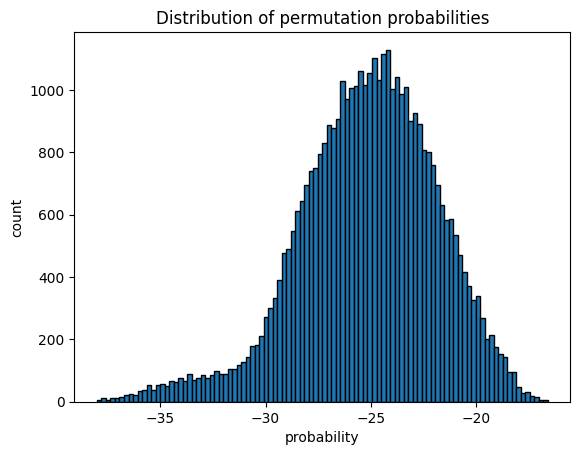

In [32]:
print(f"Max likelihood: {round(max(df_perm['log_sum'].values), 1)}")
plt.hist(df_perm["log_sum"].values, bins=100, edgecolor='black')
plt.xlabel("probability")
plt.ylabel("count")
plt.title("Distribution of permutation probabilities")
plt.show()